In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import os

HOME: str = os.getenv('HOME') # echo $HOME
USER: str = os.getenv('USER') # echo $USER
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_models = [
	"openai/clip-vit-base-patch32", # original
	"openai/clip-vit-large-patch14",
	"laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
]

if USER=="farid": # local laptop
	WDIR = os.path.join(HOME, "datasets")
	models_dir = os.path.join(WDIR, "trash", "models")
	model_fpth = pretrained_models[0]
elif USER=="alijanif": # Puhti
	WDIR = "/scratch/project_2004072/ImACCESS"
	models_dir = os.path.join(WDIR, "trash", "models")
	model_fpth = pretrained_models[1]
else: # Pouta
	WDIR = "/media/volume/ImACCESS"
	models_dir = os.path.join(HOME, WDIR, "models")
	model_fpth = pretrained_models[1]

# Load the CLIP model and processor
model = CLIPModel.from_pretrained(model_fpth, cache_dir=models_dir)
processor = CLIPProcessor.from_pretrained(model_fpth, cache_dir=models_dir)

# Load and preprocess images
# "https://www.archives.gov/files/research/military/ww2/photos/images/ww2-14.jpg"
base_url = "https://www.archives.gov/files/research/military/ww2/photos/images/ww2-"
image_urls = [f"{base_url}{i:02d}.jpg" for i in range(1, 203)]
print(f"len(image_urls): {len(image_urls)}")

images = []
for url in image_urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  images.append(img)

2024-09-27 20:38:58.876702: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 20:38:59.060570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 20:38:59.117882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 20:38:59.143587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 20:38:59.313073: I tensorflow/core/platform/cpu_feature_guar

len(image_urls): 202


In [2]:
# Encode images and text
text = "Cemetery"
inputs = processor(text=[text], images=images, return_tensors="pt", padding=True)

# Compute similarity scores
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
print(logits_per_image.shape, type(logits_per_image))
probs = logits_per_image.softmax(dim=1)  # Convert logits to probabilities
print(probs.shape, type(probs))


torch.Size([202, 1]) <class 'torch.Tensor'>
torch.Size([202, 1]) <class 'torch.Tensor'>


In [3]:
# Ensure top_k is not greater than the number of images
top_k = min(3, len(images))
top_k_indices = probs.topk(top_k, dim=0).indices.squeeze().tolist()
print(top_k_indices, type(top_k_indices))
# Handle the case where top_k_indices is not a list (e.g., when there's only one image)
if isinstance(top_k_indices, int):
  top_k_indices = [top_k_indices]

top_k_images = [images[i] for i in top_k_indices]
print(top_k_images) # [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1100x1396 at 0x78A40EF4B910>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1104x1387 at 0x78A40EF4BBB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1437x1066 at 0x78A40EA22730>]

[0, 1, 2] <class 'list'>
[<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1100x1396 at 0x78A40EF4B910>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1104x1387 at 0x78A40EF4BBB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1437x1066 at 0x78A40EA22730>]


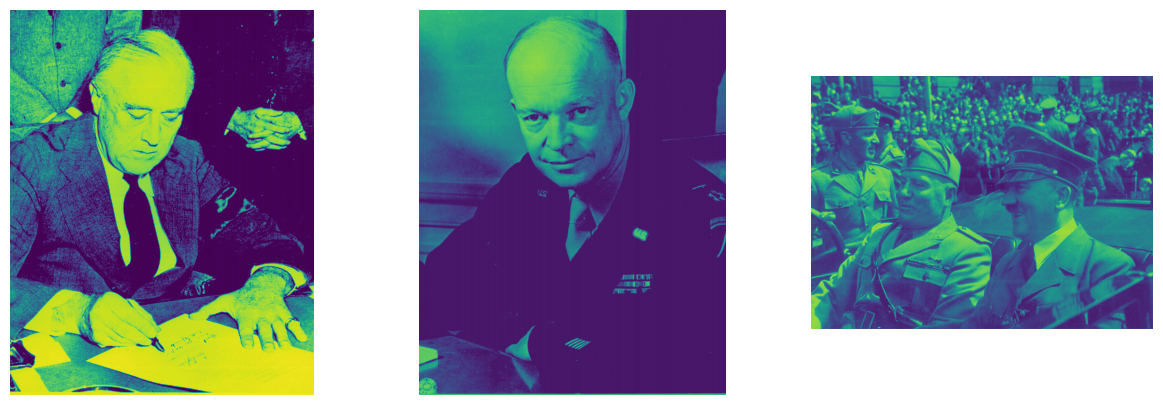

In [4]:
fig, axes = plt.subplots(1, top_k, figsize=(15, 5))
for i, img in enumerate(top_k_images):
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()